# ELEC/IEDA3180: Data-Driven Portfolio Optimization
**TUTORIAL: Machine Learning for Portfolio Construction: Random Forests**

This tutorial explores the use of random forests to **select the top quintile** stocks over a large universe of US stocks through the analysis of 10-K annual reports.

Notebook by Arnau Vilella.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

RANDOM_STATE = 4755
np.random.seed(RANDOM_STATE)

## Downloading data

In [2]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1fI7h53Bj6V8XqLhDm39c_Up8vHLY_3Lr' -O data16.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1pgjKz2Q3LfwBcHW1qeZrXTEmFLRMZY_6' -O data17.csv

--2025-08-17 14:23:04--  https://drive.google.com/uc?export=download&id=1fI7h53Bj6V8XqLhDm39c_Up8vHLY_3Lr
Resolving drive.google.com (drive.google.com)... 192.178.218.100, 192.178.218.102, 192.178.218.139, ...
Connecting to drive.google.com (drive.google.com)|192.178.218.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1fI7h53Bj6V8XqLhDm39c_Up8vHLY_3Lr&export=download [following]
--2025-08-17 14:23:04--  https://drive.usercontent.google.com/download?id=1fI7h53Bj6V8XqLhDm39c_Up8vHLY_3Lr&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.163.132, 2607:f8b0:4004:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.163.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1004358 (981K) [application/octet-stream]
Saving to: ‘data16.csv’

data16.csv          100%[===================>] 980.82K  --.-KB

## Data loading

The dataset used in this tutorial includes a list of 2707 U.S. companies, along with accounting data extracted from their 10-K annual reports. It contains numerical variables from the Income Statement, Balance Sheet, and Cash Flow Statement, as well as corresponding share prices. Four separate datasets—one for each financial statement and one for share prices—were merged to create the final dataset, which includes a total of 38 variables.

In [3]:
data16_raw = pd.read_csv("data16.csv", index_col=0)
data17_raw = pd.read_csv("data17.csv", index_col=0)

# separating target variable (annual return)
y16 = data16_raw.iloc[:, 0].copy()
data16 = data16_raw.iloc[:, 1:].copy()
y17 = data17_raw.iloc[:, 0].copy()
data17 = data17_raw.iloc[:, 1:].copy()

# removing Ticker column
ticker_col_name = data16.columns[0]
data16 = data16.drop(columns=ticker_col_name)
data17 = data17.drop(columns=ticker_col_name)

In [6]:
data16_raw.columns

Index(['shareprices2...3..shareprices1...3....1', 'Ticker', 'Shares..Basic.',
       'Shares..Diluted.', 'Revenue', 'Cost.of.Revenue', 'Gross.Profit',
       'Operating.Expenses', 'Selling..General...Administrative',
       'Research...Development', 'Operating.Income..Loss.',
       'Non.Operating.Income..Loss.', 'Interest.Expense..Net',
       'Pretax.Income..Loss...Adj.', 'Abnormal.Gains..Losses.',
       'Pretax.Income..Loss.', 'Income.Tax..Expense..Benefit..Net',
       'Income..Loss..from.Continuing.Operations',
       'Net.Extraordinary.Gains..Losses.', 'Net.Income', 'Net.Income..Common.',
       'Cash..Cash.Equivalents...Short.Term.Investments',
       'Accounts...Notes.Receivable', 'Inventories', 'Total.Current.Assets',
       'Property..Plant...Equipment..Net',
       'Long.Term.Investments...Receivables', 'Other.Long.Term.Assets',
       'Total.Noncurrent.Assets', 'Total.Assets', 'Payables...Accruals',
       'Short.Term.Debt', 'Total.Current.Liabilities', 'Long.Term.Debt',
 

## Visualization and preprocessing

This section performs the visualization of the annual returns, boxplot of features and correlation plot. Additionally, it removes highly correlated feature pairs ($\|\rho\| \geq 0.9$).

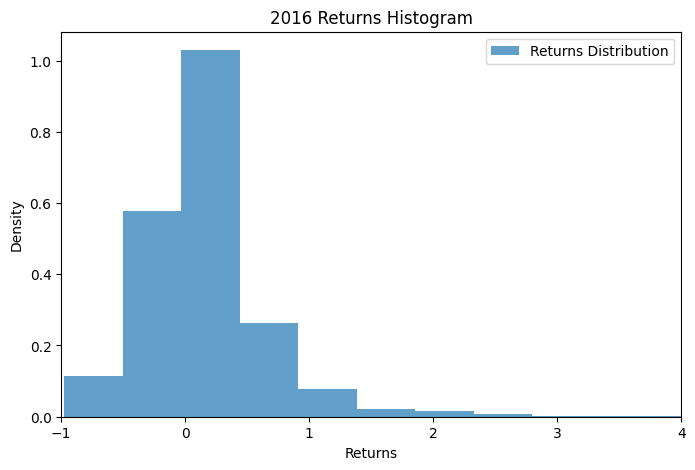

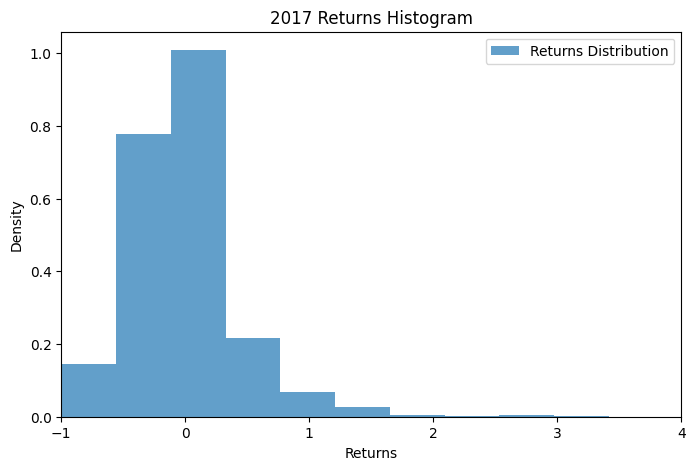

In [ ]:
# --- Visualization: annual returns ---
def plot_returns_histogram(y, year):
    plt.figure(figsize=(8, 5))
    min_val = np.floor(y.min() * 20) / 20
    max_val = np.ceil(y.max() * 20) / 208
    num_bins = int((max_val - min_val) * 20)
    if num_bins <= 0: num_bins = 10
    plt.hist(y, bins=num_bins, density=True, alpha=0.7, label='Returns Distribution')

    plt.xlim(-1, 4)
    plt.title(f'{year} Returns Histogram')
    plt.xlabel("Returns")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_returns_histogram(y16, 2016)
plot_returns_histogram(y17, 2017)

Visualizing boxplot of all features (2016)...


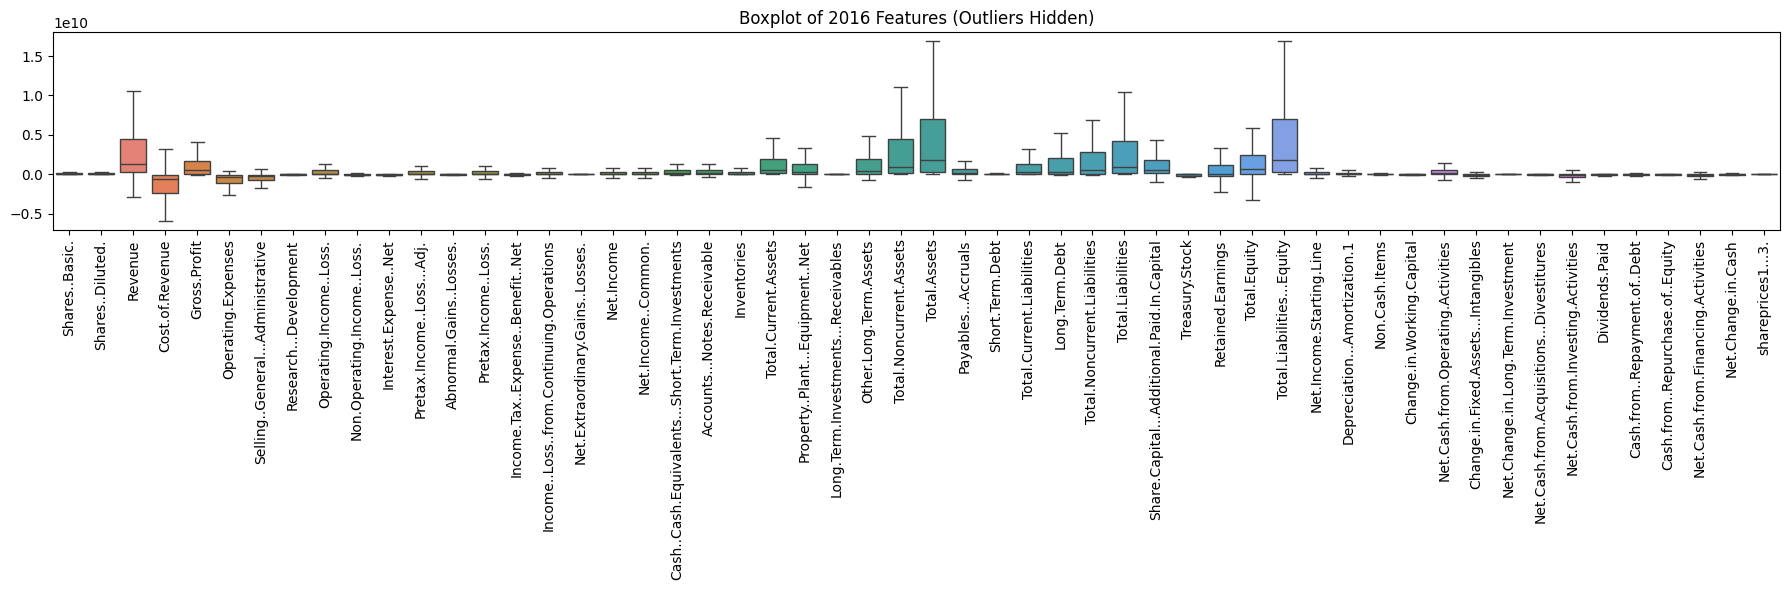

In [ ]:
# --- Visualization: boxplot for all the variables ---
print("Visualizing boxplot of all features (2016)...")
plt.figure(figsize=(18, 6))
sns.boxplot(data=data16, showfliers=False) # showfliers=False similar to outline=FALSE
plt.xticks(rotation=90)
plt.title("Boxplot of 2016 Features (Outliers Hidden)")
plt.tight_layout()
plt.show()

Calculating and visualizing correlation matrix (2016)...


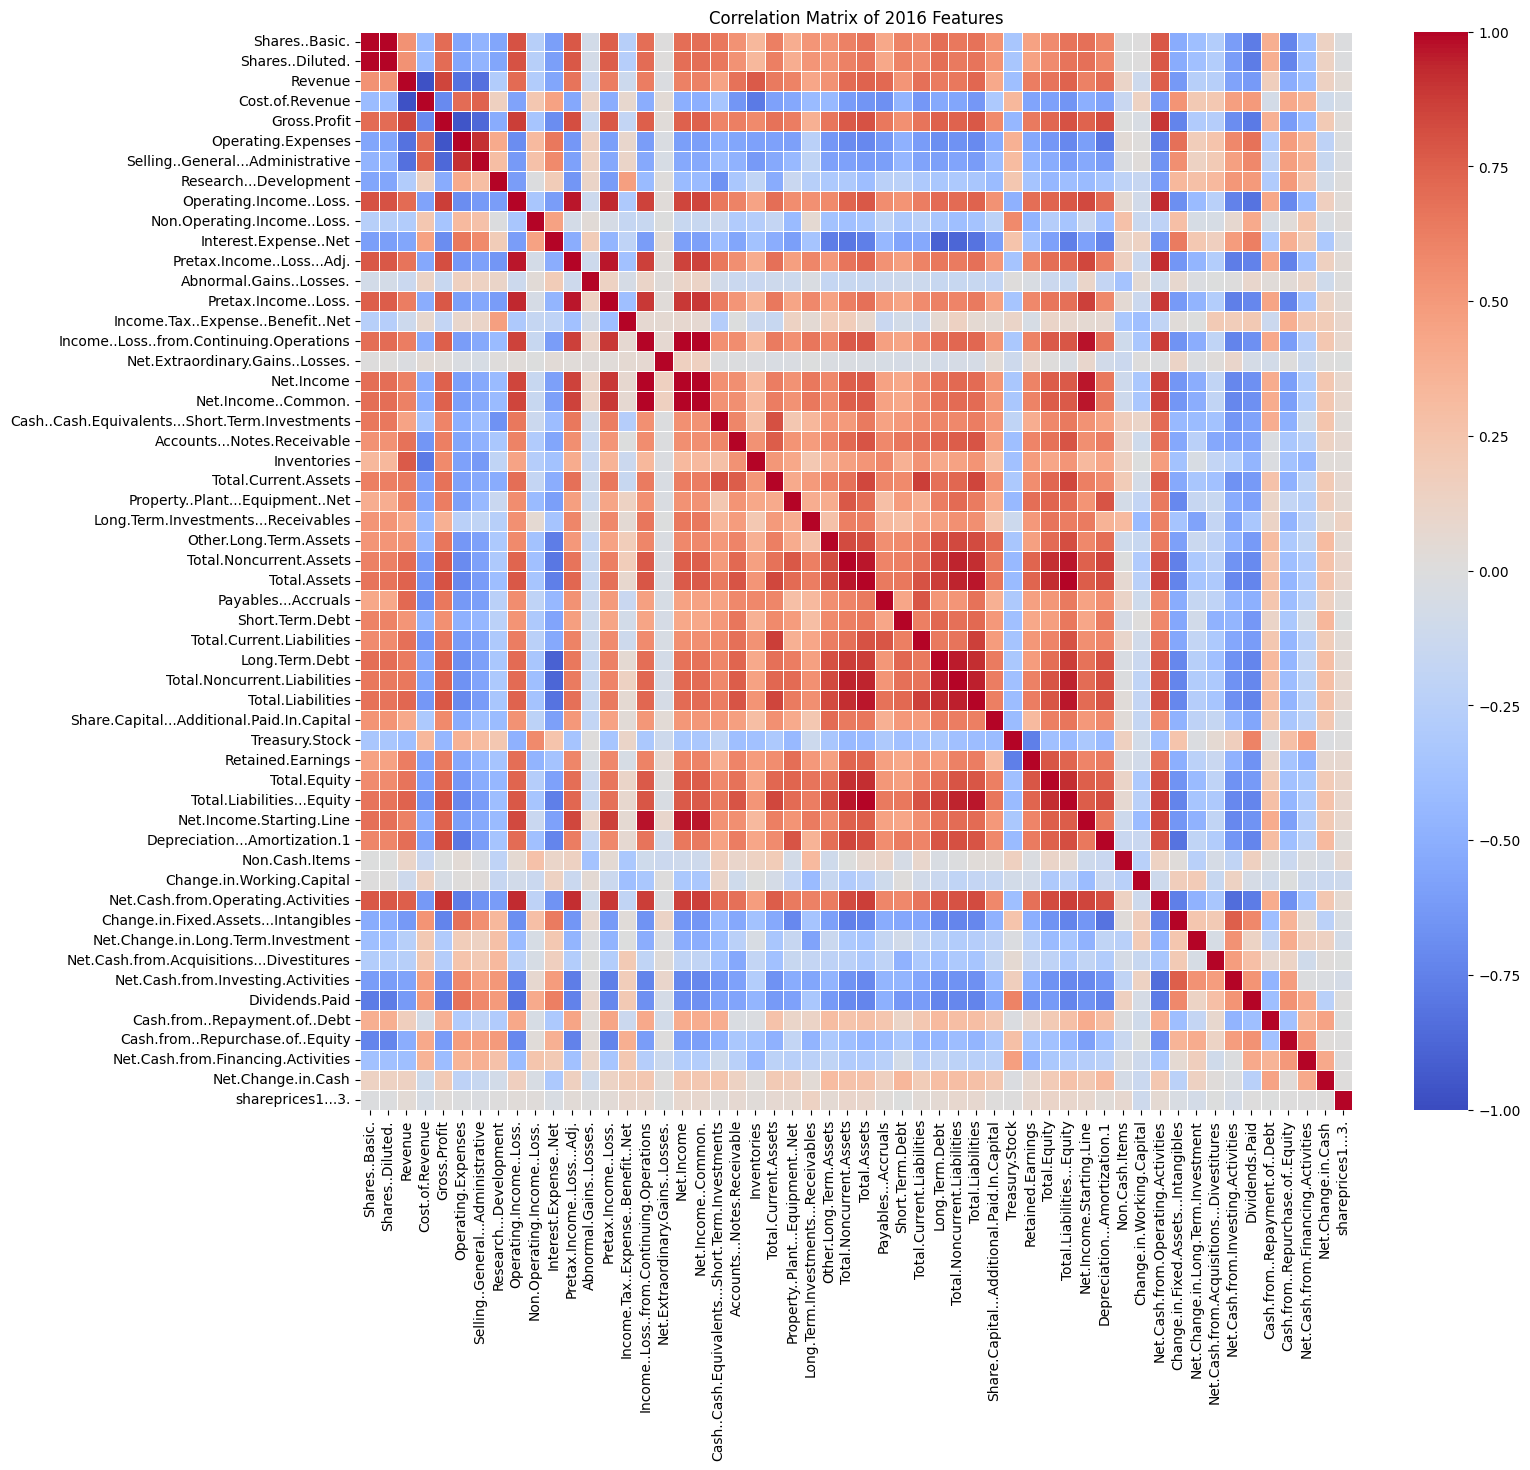

In [4]:
# --- Pair wise-correlation between variables ---
print("Calculating and visualizing correlation matrix (2016)...")
corr_matrix16 = data16.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix16, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".1f", linewidths=.5) # annot=False for speed like corrplot
plt.title("Correlation Matrix of 2016 Features")
plt.show()

Finding highly correlated features (cutoff=0.9)...
Columns to drop due to high correlation: ['Total.Liabilities...Equity', 'Gross.Profit', 'Total.Liabilities', 'Net.Income..Common.', 'Operating.Income..Loss.', 'Net.Income', 'Total.Assets', 'Pretax.Income..Loss...Adj.', 'Total.Noncurrent.Liabilities', 'Revenue', 'Shares..Basic.', 'Total.Noncurrent.Assets', 'Long.Term.Debt', 'Operating.Expenses', 'Income..Loss..from.Continuing.Operations']
Data 2016 shape after removing correlated features: (1971, 39)
Data 2017 shape after removing correlated features: (1857, 39)
Visualizing correlation matrix after removing highly correlated features...


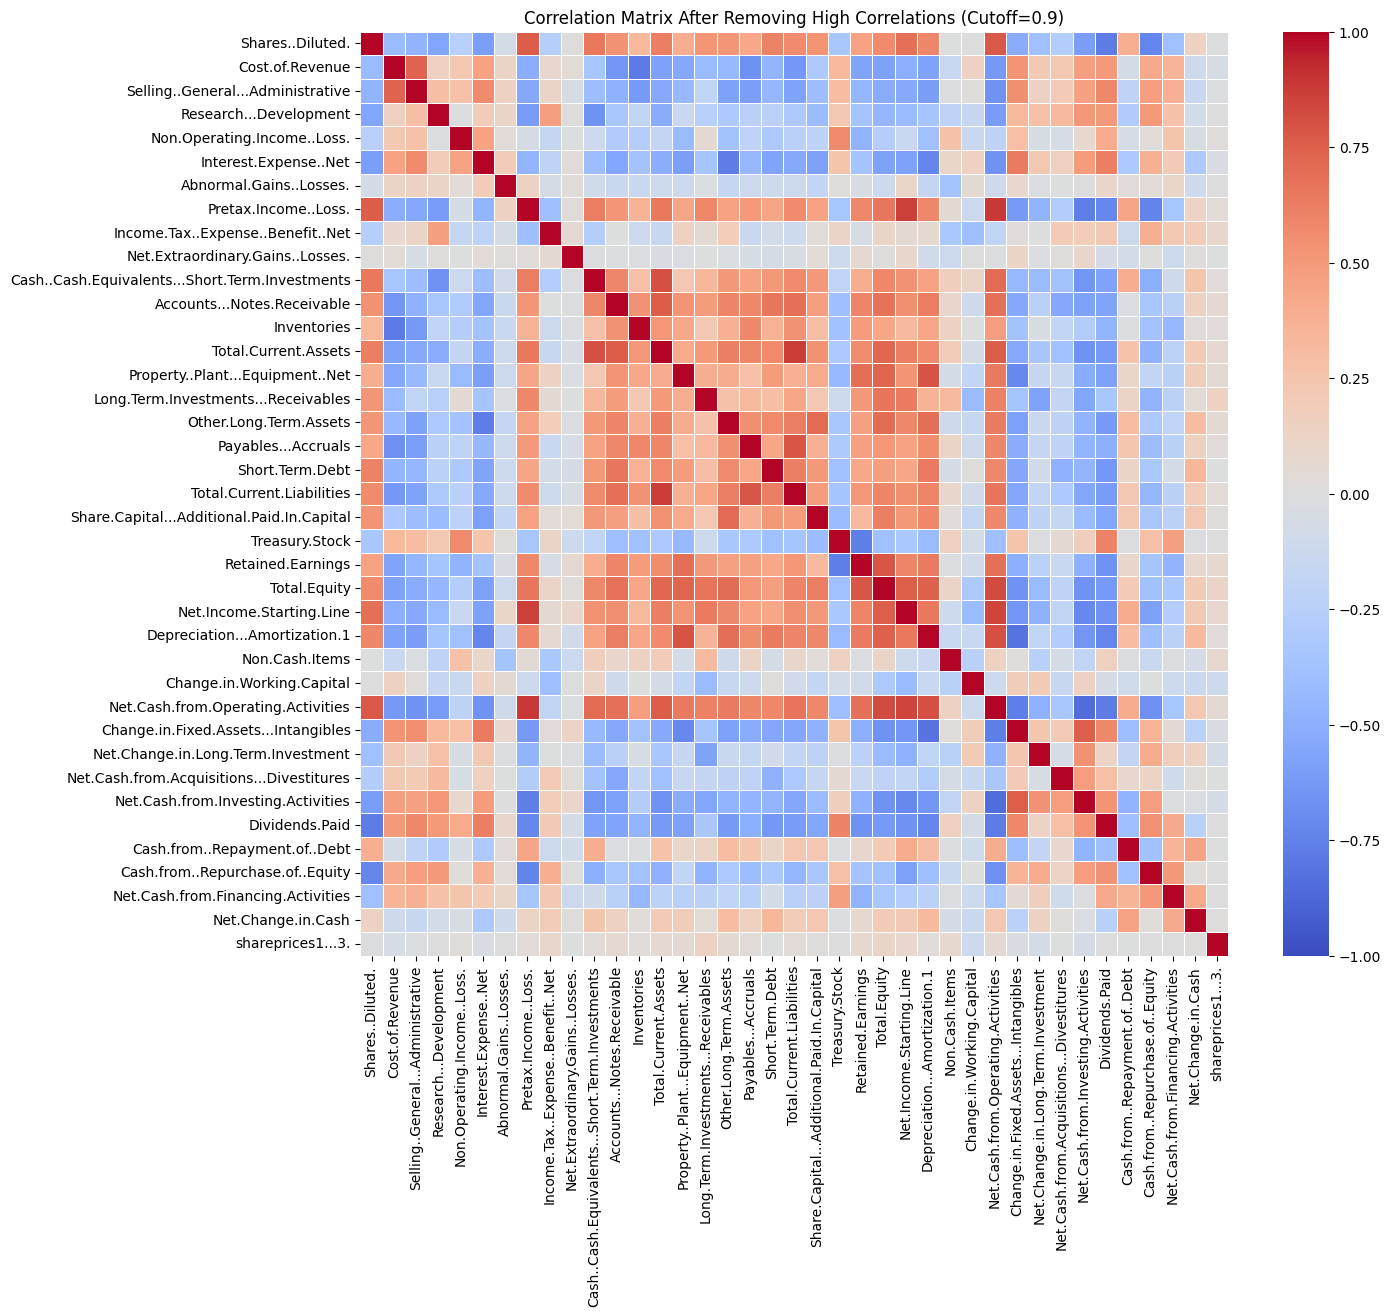

In [5]:
# --- Removal of highly correlated feature pairs (keeping only one element of the pair) ---

def find_correlation(df_corr, cutoff=0.9):
    """
    Finds highly correlated features based on a cutoff.
    Returns a list of column names to potentially remove.
    It identifies pairs above the cutoff and flags the column with the higher
    mean absolute correlation across all other columns.
    """
    highly_correlated = set()
    # Ensure the matrix is symmetric and avoid self-correlation
    corr_matrix_upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

    for col in corr_matrix_upper.columns:
        if col in highly_correlated:
            continue
        correlated_cols = corr_matrix_upper.index[abs(corr_matrix_upper[col]) > cutoff].tolist()
        if correlated_cols:
            # Add the current column and its correlated partners to a potential removal list
            cols_to_compare = [col] + correlated_cols
            mean_abs_corr = df_corr.loc[cols_to_compare, cols_to_compare].abs().mean()
            # Flag the column with the highest mean absolute correlation (excluding itself)
            col_to_remove = mean_abs_corr.idxmax()
            highly_correlated.add(col_to_remove)
            # Flag the others involved in this specific high-corr check as well, but prioritize the one flagged above
            for c in cols_to_compare:
                 if c != col_to_remove:
                     # Only add if not already flagged by a *different* check resulting in higher mean corr
                     # This logic is simplified compared to caret but captures the essence.
                     # A more robust version might re-evaluate mean correlations after each removal.
                     highly_correlated.add(c)
            # Refined logic: From the identified group, remove the one with highest mean abs corr
            # Let's try removing just one per group initially - the one with highest mean corr
            cols_to_compare = [col] + correlated_cols
            mean_abs_corr = df_corr[cols_to_compare].abs().mean() # Mean abs corr with *all* features
            col_to_remove = mean_abs_corr.idxmax()
            highly_correlated.add(col_to_remove)
            # Remove the other columns found in this specific check temporarily to avoid redundant checks
            for c in correlated_cols:
                 corr_matrix_upper[c] = 0 # Zero out column to avoid re-checking


    # Correcting the logic: caret finds pairs > cutoff, then removes the one with higher mean abs corr.
    highly_correlated_final = set()
    corr_matrix_abs = df_corr.abs()
    corr_matrix_upper_abs = corr_matrix_abs.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

    while True:
        # Find the highest correlation exceeding the cutoff
        max_corr = corr_matrix_upper_abs.max().max()
        if max_corr < cutoff:
            break # No more correlations above cutoff

        # Find the pair with this highest correlation
        row_idx, col_idx = np.where(corr_matrix_upper_abs == max_corr)
        # Get the actual column names (handle potential multiple pairs with same max corr)
        col1 = corr_matrix_upper_abs.index[row_idx[0]]
        col2 = corr_matrix_upper_abs.columns[col_idx[0]]

        # Calculate mean absolute correlation for each column in the pair
        mean_abs_corr1 = corr_matrix_abs[col1].mean()
        mean_abs_corr2 = corr_matrix_abs[col2].mean()

        # Add the column with the higher mean absolute correlation to the set to remove
        if mean_abs_corr1 > mean_abs_corr2:
            col_to_remove = col1
        else:
            col_to_remove = col2 # If equal, remove the second one

        highly_correlated_final.add(col_to_remove)

        # Remove the flagged column from consideration by setting its correlations to 0
        corr_matrix_upper_abs.loc[col_to_remove, :] = 0
        corr_matrix_upper_abs.loc[:, col_to_remove] = 0

    return list(highly_correlated_final)


print("Finding highly correlated features (cutoff=0.9)...")
cols_to_drop = find_correlation(corr_matrix16, cutoff=0.9)
print(f"Columns to drop due to high correlation: {cols_to_drop}")

data16_reduced = data16.drop(columns=cols_to_drop)
data17_reduced = data17.drop(columns=cols_to_drop)

print(f"Data 2016 shape after removing correlated features: {data16_reduced.shape}")
print(f"Data 2017 shape after removing correlated features: {data17_reduced.shape}")

print("Visualizing correlation matrix after removing highly correlated features...")
corr_matrix16_reduced = data16_reduced.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix16_reduced, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".1f", linewidths=.5)
plt.title("Correlation Matrix After Removing High Correlations (Cutoff=0.9)")
plt.show()

## Assigning class labels [TO DO]

In [9]:
# --- Processing for 2016 ---
cutoff = y16.quantile(0.8)
# Create the factor: 1 if not in top quintile, 2 if in top quintile (top 20 %)
y16_factor = (y16 >cutoff).astype(int) + 1

print("\nClass distribution for 2016 (1 if not in top quintile, 2 if in top quintile):")
counts_16 = y16_factor.value_counts().sort_index()
# Check if both classes exist before printing (handles cases where data might be skewed)
if 1 not in counts_16: counts_16[1] = 0
if 2 not in counts_16: counts_16[2] = 0
counts_16 = counts_16.sort_index() # Ensure order after potentially adding keys
for index, value in counts_16.items():
    print(f"{index}    {value}")

print("\n")
print("*" * 100)
print("\n")

# --- Processing for 2017 ---

# Create the factor: 1 if not in top quintile, 2 if in top quintile (top 20 %)
cutoff = y17.quantile(0.8)
y17_factor = (y17 > cutoff).astype(int) + 1

print("\nClass distribution for 2017 (1 if not in top quintile, 2 if in top quintile):")
counts_17 = y17_factor.value_counts().sort_index()
# Check if both classes exist before printing
if 1 not in counts_17: counts_17[1] = 0
if 2 not in counts_17: counts_17[2] = 0
counts_17 = counts_17.sort_index() # Ensure order after potentially adding keys
for index, value in counts_17.items():
    print(f"{index}    {value}")


Class distribution for 2016 (1 if not in top quintile, 2 if in top quintile):
1    1578
2    393


****************************************************************************************************



Class distribution for 2017 (1 if not in top quintile, 2 if in top quintile):
1    1485
2    372


## Train/test split

We perform train/test split. We train on 2016 data and test on 2017. However, as we want to ensure a clear separation, the stocks in the test set in 2017 won't appear on the training data of 2016.

In [10]:
# --- Scaling and train/test split ---
scaler = StandardScaler()
data16_scaled = pd.DataFrame(scaler.fit_transform(data16_reduced), index=data16_reduced.index, columns=data16_reduced.columns)
data17_scaled = pd.DataFrame(scaler.transform(data17_reduced), index=data17_reduced.index, columns=data17_reduced.columns) # Use the same scaler

# Using sklearn's train_test_split for simplicity and stratification
X_train, X_test_16, y_train, y_test_16 = train_test_split(
    data16_scaled,
    y16_factor,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y16_factor # Keep class proportions
)

y_test_16_return = y16.loc[X_test_16.index]

print(f"Training set shape: {X_train.shape}")
print(f"Test set 2016 shape: {X_test_16.shape}")

tickers16_index = data16_scaled.index
tickers17_index = data17_scaled.index
tickers_test_16_index = X_test_16.index

tickers_shared_test = tickers17_index.intersection(tickers_test_16_index)

X_test_17 = data17_scaled.loc[tickers_shared_test]
y_test_17 = y17_factor.loc[tickers_shared_test]
y_test_17_return = y17.loc[tickers_shared_test]

print(f"Test set 2017 shape (new + 2016 test tickers): {X_test_17.shape}")

Training set shape: (1478, 39)
Test set 2016 shape: (493, 39)
Test set 2017 shape (new + 2016 test tickers): (467, 39)


## Cross-Validation Setup

**K-Fold Cross-Validation** is a robust method for estimating a model's generalization performance by partitioning the dataset $D$ into $k$ non-overlapping, typically equal-sized subsets called folds ($F_1, \dots, F_k$), often employing stratification for classification tasks. The procedure iterates $k$ times, where in each iteration $i$, fold $F_i$ is held out as the validation set, and the model is trained on the remaining $k-1$ folds ($D \setminus F_i$). The performance metric is computed on the validation set $F_i$, and the final cross-validation estimate is typically the average of the metrics obtained across all $k$ iterations, providing a less variable assessment of model capability on unseen data compared to a single train-test split by utilizing all data points for both training and validation.

In [11]:
# --- Cross-Validation Setup ---
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

## Decision Trees

In [ ]:
# --- Single Tree ---
cv_results_tree = {'fold': [], 'TR error': [], 'VA error': []}
fold_counter = 1

for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    my_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    my_tree.fit(X_cv_train, y_cv_train)

    pred_train = my_tree.predict(X_cv_train)
    pred_val = my_tree.predict(X_cv_val)

    tr_error = 1.0 - accuracy_score(y_cv_train, pred_train)
    va_error = 1.0 - accuracy_score(y_cv_val, pred_val)

    cv_results_tree['fold'].append(fold_counter)
    cv_results_tree['TR error'].append(tr_error)
    cv_results_tree['VA error'].append(va_error)
    fold_counter += 1

cv_results_tree_df = pd.DataFrame(cv_results_tree)
print("CV Results (Single Tree):")
print(cv_results_tree_df)
mean_va_error_tree = cv_results_tree_df['VA error'].mean()
print(f"\nMean Validation Error (Single Tree): {mean_va_error_tree:.4f}")

CV Results (Single Tree):
   fold  TR error  VA error
0     1       0.0  0.250000
1     2       0.0  0.297297
2     3       0.0  0.324324
3     4       0.0  0.250000
4     5       0.0  0.304054
5     6       0.0  0.371622
6     7       0.0  0.331081
7     8       0.0  0.263514
8     9       0.0  0.238095
9    10       0.0  0.278912

Mean Validation Error (Single Tree): 0.2909


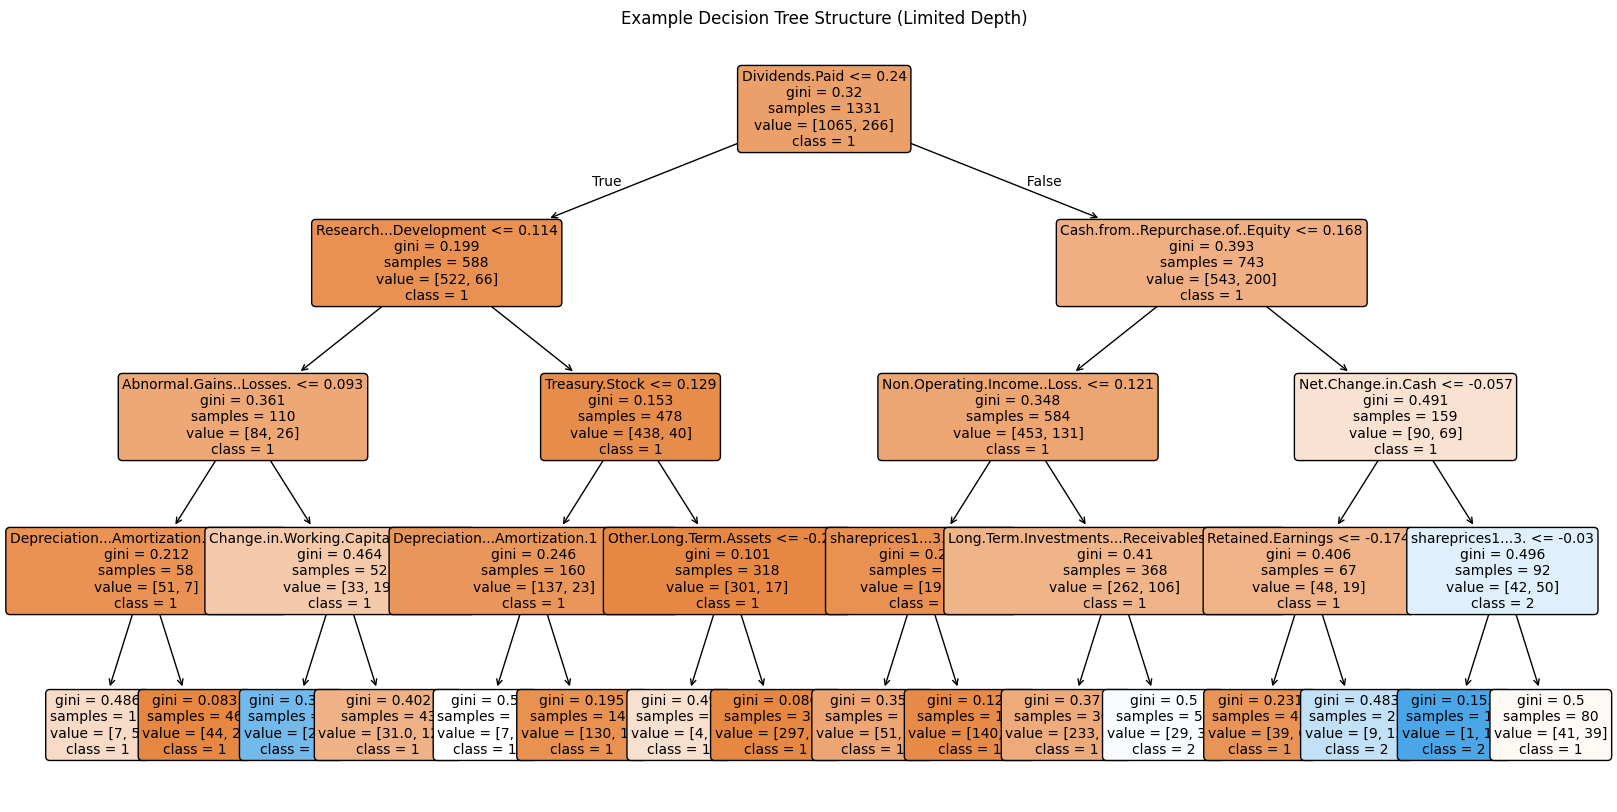

In [ ]:
# --- Single Tree model visualization ---
feature_names = X_train.columns.tolist()
class_names = [str(c) for c in sorted(y_train.unique())] # ['1', '2']

last_train_idx, last_val_idx = list(cv.split(X_train, y_train))[-1]
X_last_cv_train, y_last_cv_train = X_train.iloc[last_train_idx], y_train.iloc[last_train_idx]
final_tree_viz = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4) # Limit depth for viz
final_tree_viz.fit(X_last_cv_train, y_last_cv_train)


plt.figure(figsize=(20, 10))
plot_tree(final_tree_viz,
          filled=True,
          rounded=True,
          feature_names=feature_names,
          class_names=class_names,
          fontsize=10)
plt.title("Example Decision Tree Structure (Limited Depth)")
plt.show()

## Random Forest [TO DO]

In [12]:
# --- Random Forest ---
print("\n--- Training Random Forest (ntree=200) with Cross-Validation ---")
cv_results_rf = {'fold': [], 'TR error': [], 'VA error': []}
fold_counter = 1
for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train Random Forest
    # n_estimators corresponds to ntree
    # random_state ensures reproducibility of the forest
    my_rforest = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1) # Use all cores
    my_rforest.fit(X_cv_train, y_cv_train)

    # Predict and calculate errors
    pred_train = my_rforest.predict(X_cv_train)
    pred_val = my_rforest.predict(X_cv_val)

    tr_error = 1.0 - accuracy_score(y_cv_train, pred_train)
    va_error = 1.0 - accuracy_score(y_cv_val, pred_val)

    cv_results_rf['fold'].append(fold_counter)
    cv_results_rf['TR error'].append(tr_error)
    cv_results_rf['VA error'].append(va_error)
    fold_counter += 1

cv_results_rf_df = pd.DataFrame(cv_results_rf)
print("CV Results (Random Forest n_estimators=200):")
print(cv_results_rf_df)
mean_va_error_rf = cv_results_rf_df['VA error'].mean()
print(f"\nMean Validation Error (Random Forest n_estimators=200): {mean_va_error_rf:.4f}")


--- Training Random Forest (ntree=200) with Cross-Validation ---
CV Results (Random Forest n_estimators=200):
   fold  TR error  VA error
0     1       0.0  0.202703
1     2       0.0  0.202703
2     3       0.0  0.202703
3     4       0.0  0.195946
4     5       0.0  0.195946
5     6       0.0  0.195946
6     7       0.0  0.202703
7     8       0.0  0.195946
8     9       0.0  0.210884
9    10       0.0  0.190476

Mean Validation Error (Random Forest n_estimators=200): 0.1996


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


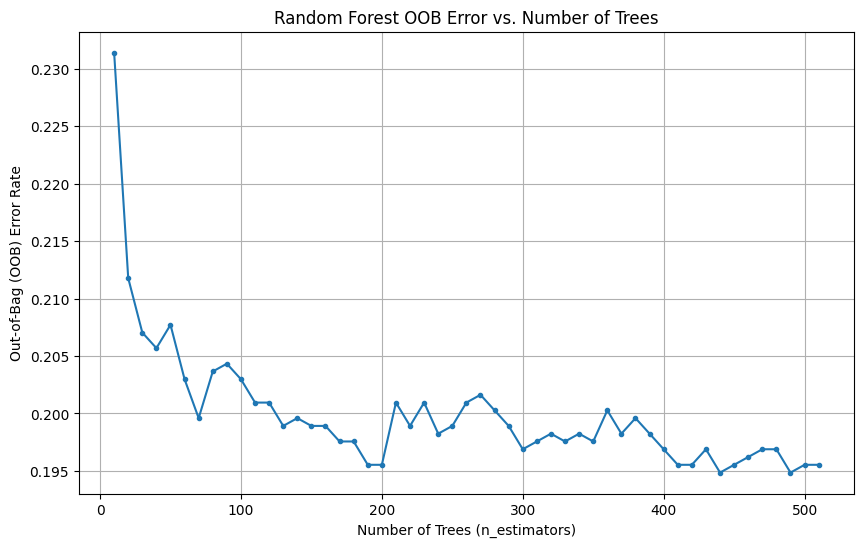

In [13]:
# --- Random Forest tunning ---
rf_oob = RandomForestClassifier(n_estimators=512,
                                random_state=RANDOM_STATE,
                                oob_score=True,
                                n_jobs=-1,
                                warm_start=True)

oob_errors = []
min_estimators = 10
for n_estimators in range(min_estimators, 513, 10):
    rf_oob.set_params(n_estimators=n_estimators)
    rf_oob.fit(X_train, y_train)
    if rf_oob.oob_score_:
        oob_errors.append(1.0 - rf_oob.oob_score_)
    else:
        oob_errors.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(range(min_estimators, 513, 10), oob_errors, marker='.')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Out-of-Bag (OOB) Error Rate")
plt.title("Random Forest OOB Error vs. Number of Trees")
plt.grid(True)
plt.show()

In [14]:
# --- Getting the metrics for the final version of the Random Forest --- [TO DO]
print("\n--- Training Improved Random Forest (ntree=200, balanced) with Cross-Validation ---")

k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

cv_results_rf_imp = {'fold': [], 'TR error': [], 'VA error': [], 'Precision': [], 'Classification Rate': [], 'Recall': []}
fold_counter = 1

for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train Improved Random Forest
    my_rforest_imp = RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    my_rforest_imp.fit(X_cv_train, y_cv_train)

    # Predict on training and validation sets
    pred_train = my_rforest_imp.predict(X_cv_train)
    pred_val = my_rforest_imp.predict(X_cv_val)

    # Calculate metrics for the validation set
    tr_error = 1.0 - accuracy_score(y_cv_train, pred_train)
    va_error = 1.0 - accuracy_score(y_cv_val, pred_val)
    precision = precision_score(y_cv_val, pred_val, pos_label=2, zero_division=0) # R uses 1 if NaN, sklearn uses 0
    recall = recall_score(y_cv_val, pred_val, pos_label=2, zero_division=0)
    # Classification rate is just accuracy in this binary case
    class_rate = accuracy_score(y_cv_val, pred_val)

    cv_results_rf_imp['fold'].append(fold_counter)
    cv_results_rf_imp['TR error'].append(tr_error)
    cv_results_rf_imp['VA error'].append(va_error)
    cv_results_rf_imp['Precision'].append(precision if not np.isnan(precision) else 1.0) # NaN -> 1 for precision
    cv_results_rf_imp['Classification Rate'].append(class_rate)
    cv_results_rf_imp['Recall'].append(recall if not np.isnan(recall) else 1.0) # NaN -> 1 for recall
    fold_counter += 1

cv_results_rf_imp_df = pd.DataFrame(cv_results_rf_imp)
print("CV Results (Improved Random Forest):")
print(cv_results_rf_imp_df)

print("\nCV Error (Mean Validation Error):")
mean_va_error_rf_imp = cv_results_rf_imp_df['VA error'].mean()
print(f"{mean_va_error_rf_imp:.4f}")

print("Precision (Mean Validation):")
mean_precision_rf_imp = cv_results_rf_imp_df['Precision'].mean()
print(f"{mean_precision_rf_imp:.4f}")

print("Classification Rate (Mean Validation Accuracy):")
mean_class_rate_rf_imp = cv_results_rf_imp_df['Classification Rate'].mean()
print(f"{mean_class_rate_rf_imp:.4f}")

print("Recall (Mean Validation):")
mean_recall_rf_imp = cv_results_rf_imp_df['Recall'].mean()
print(f"{mean_recall_rf_imp:.4f}")


--- Training Improved Random Forest (ntree=200, balanced) with Cross-Validation ---
CV Results (Improved Random Forest):
   fold  TR error  VA error  Precision  Classification Rate    Recall
0     1       0.0  0.202703   0.333333             0.797297  0.034483
1     2       0.0  0.202703   0.333333             0.797297  0.034483
2     3       0.0  0.202703   0.428571             0.797297  0.103448
3     4       0.0  0.195946   0.600000             0.804054  0.100000
4     5       0.0  0.195946   0.666667             0.804054  0.066667
5     6       0.0  0.195946   0.666667             0.804054  0.066667
6     7       0.0  0.202703   0.500000             0.797297  0.100000
7     8       0.0  0.195946   0.600000             0.804054  0.100000
8     9       0.0  0.210884   0.250000             0.789116  0.034483
9    10       0.0  0.190476   1.000000             0.809524  0.034483

CV Error (Mean Validation Error):
0.1996
Precision (Mean Validation):
0.5379
Classification Rate (Mean Vali

In [15]:
# --- Test Random Forest --- [TO DO]
print("\n--- Testing Final Random Forest Model on Hold-Out Sets ---")

# Train the final model on the *full* training set (X_train, y_train)
final_rforest = RandomForestClassifier(
    n_estimators=200,  # TO DO
    random_state=RANDOM_STATE,
    n_jobs=-1
)
final_rforest.fit(X_train, y_train)

# Evaluate on 2016 Test Set (X_test_16, y_test_16)
pred_test_16 = final_rforest.predict(X_test_16)
print("\n--- 2016 Test Set Performance ---")
test_16_error = 1.0 - accuracy_score(y_test_16, pred_test_16)
test_16_precision = precision_score(y_test_16, pred_test_16, pos_label=2, zero_division=0)
test_16_recall = recall_score(y_test_16, pred_test_16, pos_label=2, zero_division=0)
test_16_class_rate = accuracy_score(y_test_16, pred_test_16)

print(f"2016 test error (1 - accuracy): {test_16_error:.4f}")
print(f"2016 test precision: {test_16_precision:.4f}")
print(f"2016 test classification rate (accuracy): {test_16_class_rate:.4f}")
print(f"2016 test recall: {test_16_recall:.4f}")

# Evaluate on 2017 Test Set (X_test_17, y_test_17)
pred_test_17 = final_rforest.predict(X_test_17)
print("\n--- 2017 Test Set Performance (New + 2016 Test Tickers) ---")
test_17_error = 1.0 - accuracy_score(y_test_17, pred_test_17)
test_17_precision = precision_score(y_test_17, pred_test_17, pos_label=2, zero_division=0)
test_17_recall = recall_score(y_test_17, pred_test_17, pos_label=2, zero_division=0)
test_17_class_rate = accuracy_score(y_test_17, pred_test_17)

print(f"2017 test error (1 - accuracy): {test_17_error:.4f}")
print(f"2017 test precision: {test_17_precision:.4f}")
print(f"2017 test classification rate (accuracy): {test_17_class_rate:.4f}")
print(f"2017 test recall: {test_17_recall:.4f}")


--- Testing Final Random Forest Model on Hold-Out Sets ---

--- 2016 Test Set Performance ---
2016 test error (1 - accuracy): 0.1968
2016 test precision: 0.5217
2016 test classification rate (accuracy): 0.8032
2016 test recall: 0.1224

--- 2017 Test Set Performance (New + 2016 Test Tickers) ---
2017 test error (1 - accuracy): 0.1991
2017 test precision: 0.3684
2017 test classification rate (accuracy): 0.8009
2017 test recall: 0.0795


In [16]:
# --- Full Dataset Random Forest --- [TO DO]
print("\n--- Training Random Forest on FULL 2016 Data, Testing on FULL 2017 Data ---")

# Use the full scaled 2016 data (R-style scaling)
full_rforest = RandomForestClassifier(
    n_estimators=200,  # TO DO
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# Target is y16_factor (full dataset)
full_rforest.fit(data16_scaled, y16_factor)

# Test on the full scaled 2017 data
pred_full_17 = full_rforest.predict(data17_scaled)
# Target is y17_factor (full dataset)
print("\n--- Full 2017 Test Set Performance ---")
full_test_17_error = 1.0 - accuracy_score(y17_factor, pred_full_17)
full_test_17_precision = precision_score(y17_factor, pred_full_17, pos_label=2, zero_division=0)
full_test_17_recall = recall_score(y17_factor, pred_full_17, pos_label=2, zero_division=0)
full_test_17_class_rate = accuracy_score(y17_factor, pred_full_17)

print(f"Full 2017 test error (1 - accuracy): {full_test_17_error:.4f}")
print(f"Full 2017 test precision: {full_test_17_precision:.4f}")
print(f"Full 2017 test classification rate (accuracy): {full_test_17_class_rate:.4f}")
print(f"Full 2017 test recall: {full_test_17_recall:.4f}")


--- Training Random Forest on FULL 2016 Data, Testing on FULL 2017 Data ---

--- Full 2017 Test Set Performance ---
Full 2017 test error (1 - accuracy): 0.1998
Full 2017 test precision: 0.5062
Full 2017 test classification rate (accuracy): 0.8002
Full 2017 test recall: 0.1102


## Backtesting [TO DO]

We will perform a backtest with the stocks predicted as top quintile for 2017. The backtest starts in April, as the 10-K report might not be available until then.

We will compare the performance of a monthly rebalanced Markovitz portfolio (same as question 1 in the midterm) and an equally weighted portfolio with the performance of the S&P 500 index.

In [ ]:
!pip install --upgrade yfinance

In [17]:
import yfinance as yf
import cvxpy as cp

In [18]:
len(pred_test_16)

493

x_test16: 493, sendo 23 classe 2

pred_full_17: 1857 sendo 81 de classe 2

In [19]:
# --- Getting the selected stocks ---

print("\n--- 2016 Test Set Index ---")
selected_tickers_16 = X_test_16.index[pred_test_16 == 2]
num_companies_index_16 = len(selected_tickers_16)
print(f"Number of companies in 2016 test index: {num_companies_index_16}")

print("\n--- Full 2017 Dataset Index (Model Trained on Full 2016 Data) ---")
selected_tickers_full_17 = data17_scaled.index[pred_full_17 == 2]
num_companies_index_full_17 = len(selected_tickers_full_17)
print(f"Number of companies in our index: {num_companies_index_full_17}")


--- 2016 Test Set Index ---
Number of companies in 2016 test index: 23

--- Full 2017 Dataset Index (Model Trained on Full 2016 Data) ---
Number of companies in our index: 81


selected_tickers_list: lista dos 81 tickets  

In [20]:
# --- 0. User inputs ---
original_tickers = data17_raw.loc[data17_scaled.index, 'Ticker'].values
selected_tickers_list = original_tickers[pred_full_17 == 2].tolist()

start_date = "2017-04-01"  # 10-K reports are not made available until April
end_date   = "2018-01-02"
rebalance_freq = 21              # rebalance every 21 trading days

print("\n--- Starting Walk-Forward Backtesting ---")
print(f"Initial number of selected stocks: {len(selected_tickers_list)}")


--- Starting Walk-Forward Backtesting ---
Initial number of selected stocks: 81


armazena em clean_tickers apenas os que saõ encontrados p/ yfinance

In [ ]:
# --- 1. Filter out tickers that yfinance can't fetch ---

# IMPORTANT: We filter out before the backtesting period. This doens't include
# survivorship bias, only removes tickers that are not fetched by yfinance.

clean_tickers = []
for ticker in selected_tickers_list:
    try:
        _ = yf.download(ticker, start="2017-03-31", end="2017-03-31",
                        progress=False, threads=False)
        clean_tickers.append(ticker)
    except Exception as e:
        # print(f" → Error for {ticker}: {e.__class__.__name__}; removing.")
        pass
print(f"Tickers after filtering invalid symbols: {len(clean_tickers)}")

if not clean_tickers:
    raise SystemExit("No valid tickers remain. Exiting backtest.")

In [23]:
# --- 2. Bulk-download price data --- [TO DO]
print(f"Downloading data for {len(clean_tickers)} tickers...")
price_data = yf.download(clean_tickers,  # TO DO
                         start=start_date,
                         end=end_date,
                         progress=False)

# Download S&P 500 data
print("Downloading S&P 500 data...")
sp500_data = yf.download(clean_tickers,  # TO DO
                         start=start_date,
                         end=end_date,
                         progress=False)

close = ( price_data['Close']
          .ffill()  # Forward fill to keep last valid price
          .dropna(axis=1, how='all')
          .dropna(axis=1, how='any') )
close = close.loc["2017-01-01":"2017-12-31"]

sp500_close = sp500_data['Close'].ffill()
sp500_close = sp500_close.loc["2017-01-01":"2017-12-31"]

print(f"Data: {close.shape[1]} tickers, {close.shape[0]} days "
      f"({close.index.min().date()} to {close.index.max().date()})")

/tmp/ipython-input-4220635323.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(clean_tickers,  # TO DO
ERROR:yfinance:
23 Failed downloads:
ERROR:yfinance:['BLUE', 'SRRA', 'ACRX', 'ARNA', 'SGH', 'ARQL', 'SPLK', 'AYX', 'GBT', 'ZEN', 'MMMB', 'SQ', 'BGNE', 'HPJ', 'SESN', 'TWOU', 'ZGNX', 'NEWR', 'GLYC', 'RHT', 'ABMD']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['FB', 'BCOR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-04-01 -> 2018-01-02) (Yahoo error = "Data doesn\'t exist for startDate = 1491019200, endDate = 1514869200")')
/tmp/ipython-input-4220635323.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_data = yf.download(clean_tickers,  # TO DO


ERROR:yfinance:
23 Failed downloads:
ERROR:yfinance:['BLUE', 'SRRA', 'ACRX', 'ARNA', 'SGH', 'ARQL', 'SPLK', 'GBT', 'AYX', 'ZEN', 'SQ', 'MMMB', 'BGNE', 'HPJ', 'SESN', 'TWOU', 'ZGNX', 'NEWR', 'GLYC', 'RHT', 'ABMD']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['FB', 'BCOR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-04-01 -> 2018-01-02) (Yahoo error = "Data doesn\'t exist for startDate = 1491019200, endDate = 1514869200")')


Data: 56 tickers, 189 days (2017-04-03 to 2017-12-29)


In [ ]:
# --- 3. Setup backtest containers --- [TO DO]
# Calculate log returns instead of simple returns
returns = ...  # TO DO
sp500_returns = ...  # TO DO
n_assets = returns.shape[1]

# Containers for both portfolios
markowitz_weights_list = []
equal_weights_list = []  # 1/N portfolio weights
rebalance_dates = []
markowitz_ret_series = pd.Series(dtype=float)
equal_ret_series = pd.Series(dtype=float)  # 1/N portfolio returns

In [ ]:
# --- 4. Walk-forward loop (apply weights to every day) --- [TO DO]
rebalance_indices = list(range(0, len(returns), rebalance_freq))

for idx in rebalance_indices:
    # 4a) compute weights based on most recent look-back window
    if idx == 0:
        # initial 1/N for both portfolios
        w_markowitz = np.ones(n_assets) / n_assets
        w_equal = np.ones(n_assets) / n_assets
    else:
        train = returns.iloc[idx-rebalance_freq : idx]
        Sigma = train.cov()
        mu = train.mean().values
        lambda_ = 5

        # Markowitz portfolio
        w_var = cp.Variable(n_assets)
        prob = cp.Problem(...)  # TO DO
        prob.solve()
        w_markowitz = w_var.value

        # Equally weighted portfolio (equal weights)
        w_equal = np.ones(n_assets) / n_assets

    # record weights & rebalance date
    markowitz_weights_list.append(w_markowitz)
    equal_weights_list.append(w_equal)
    rebalance_dates.append(returns.index[idx])

    # 4b) apply these weights to each trading day until next rebalance
    next_idx = idx + rebalance_freq
    test = returns.iloc[idx : next_idx]

    # Calculate returns for both portfolios
    markowitz_test_ret = test.dot(w_markowitz)
    equal_test_ret = test.dot(w_equal)

    # concatenate daily returns
    markowitz_ret_series = pd.concat([markowitz_ret_series, markowitz_test_ret])
    equal_ret_series = pd.concat([equal_ret_series, equal_test_ret])

/tmp/ipykernel_266280/2624561793.py:45: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  markowitz_ret_series = pd.concat([markowitz_ret_series, markowitz_test_ret])
/tmp/ipykernel_266280/2624561793.py:46: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  equal_ret_series = pd.concat([equal_ret_series, equal_test_ret])


/tmp/ipykernel_266280/1329337233.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sp500_return = float(sp500_cum_ret.iloc[-1]/sp500_cum_ret.iloc[0]-1)



=== Portfolio Performance Comparison ===
Markowitz Portfolio:
Cumulative return: 73.13%
Sharpe ratio (rf=0): 1.68

1/N Portfolio:
Cumulative return: 58.80%
Sharpe ratio (rf=0): 3.72

S&P 500:
Cumulative return: 13.28%
Sharpe ratio (rf=0): 2.50


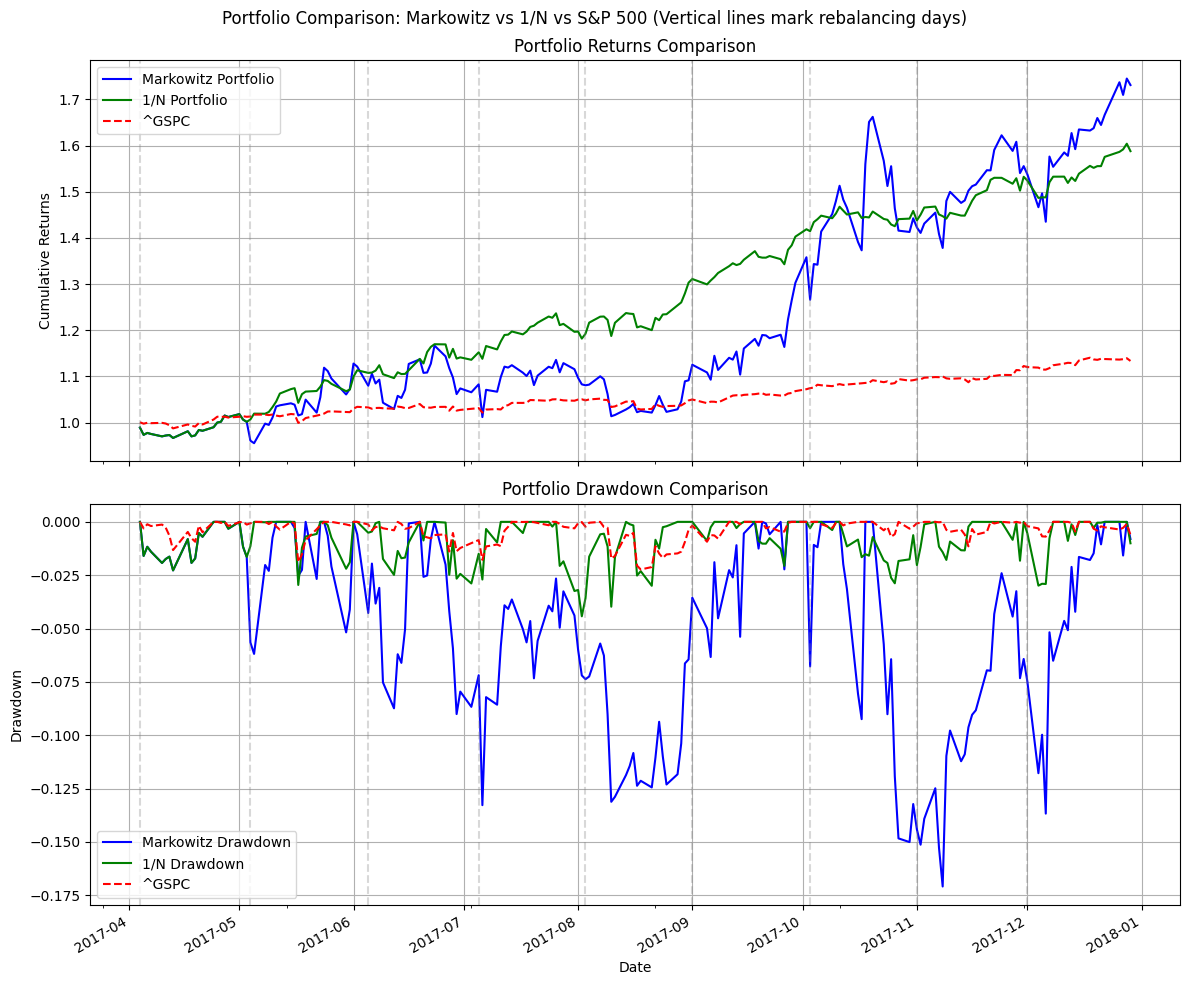

In [ ]:
# --- 5. RESULTS & PLOT ---

# Calculate cumulative returns for both portfolios and S&P 500
markowitz_cum_ret = np.exp(markowitz_ret_series.cumsum())
equal_cum_ret = np.exp(equal_ret_series.cumsum())
sp500_cum_ret = np.exp(sp500_returns.cumsum())

# Calculate performance metrics for both portfolios and S&P 500
markowitz_ann_return = markowitz_ret_series.mean() * 252
markowitz_ann_vol = markowitz_ret_series.std() * np.sqrt(252)
markowitz_sharpe = markowitz_ann_return / markowitz_ann_vol

equal_ann_return = equal_ret_series.mean() * 252
equal_ann_vol = equal_ret_series.std() * np.sqrt(252)
equal_sharpe = equal_ann_return / equal_ann_vol

sp500_ann_return = sp500_returns.mean() * 252
sp500_ann_vol = sp500_returns.std() * np.sqrt(252)
sp500_sharpe = sp500_ann_return / sp500_ann_vol

print("\n=== Portfolio Performance Comparison ===")
print("Markowitz Portfolio:")
print(f"Cumulative return: {markowitz_cum_ret.iloc[-1]-1:.2%}")
print(f"Sharpe ratio (rf=0): {markowitz_sharpe:.2f}")
print("\nEqually Weighted Top Quintile Portfolio:")
print(f"Cumulative return: {equal_cum_ret.iloc[-1]-1:.2%}")
print(f"Sharpe ratio (rf=0): {equal_sharpe:.2f}")
print("\nS&P 500:")
sp500_return = float(sp500_cum_ret.iloc[-1]/sp500_cum_ret.iloc[0]-1)
print(f"Cumulative return: {sp500_return:.2%}")
print(f"Sharpe ratio (rf=0): {float(sp500_sharpe.iloc[0]):.2f}")

# plot both portfolios and S&P 500
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10), sharex=True)

# Calculate drawdowns for all portfolios
markowitz_rolling_max = markowitz_cum_ret.expanding().max()
markowitz_drawdown = (markowitz_cum_ret - markowitz_rolling_max) / markowitz_rolling_max

equal_rolling_max = equal_cum_ret.expanding().max()
equal_drawdown = (equal_cum_ret - equal_rolling_max) / equal_rolling_max

sp500_rolling_max = sp500_cum_ret.expanding().max()
sp500_drawdown = (sp500_cum_ret - sp500_rolling_max) / sp500_rolling_max

# Plot portfolio returns on top
markowitz_cum_ret.plot(ax=ax1, color='blue', label='Markowitz Portfolio')
equal_cum_ret.plot(ax=ax1, color='green', label='Equally weighted Top Quintile Portfolio')
sp500_cum_ret.plot(ax=ax1, color='red', label='S&P 500', linestyle='--')
ax1.set_ylabel('Cumulative Returns')
ax1.set_title('Portfolio Returns Comparison')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot drawdowns on bottom
markowitz_drawdown.plot(ax=ax2, color='blue', label='Markowitz Drawdown')
equal_drawdown.plot(ax=ax2, color='green', label='Equally weighted Top Quintile Drawdown')
sp500_drawdown.plot(ax=ax2, color='red', label='S&P 500 Drawdown', linestyle='--')
ax2.set_ylabel('Drawdown')
ax2.set_xlabel('Date')
ax2.set_title('Portfolio Drawdown Comparison')
ax2.grid(True)
ax2.legend(loc='lower left')

# Add vertical lines for rebalancing days on both plots
for date in rebalance_dates:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.3)
    ax2.axvline(x=date, color='gray', linestyle='--', alpha=0.3)

plt.suptitle("Portfolio Comparison: Markowitz vs Equally weighted Top Quintile vs S&P 500 (Vertical lines mark rebalancing days)")
plt.tight_layout()
plt.show()